In [1]:
import cv2
import os
import sklearn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Base path and labels
base_path = './'
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

# Constants
IMAGE_SIZE = 150
BATCH_SIZE = 16
VERBOSE = 1

###### Reading the dataset

In [3]:
x_train=[]
y_train=[]

# Loading Training Datasets from folders
for i in class_names:
    folderPath = os.path.join(os.path.join(base_path,'Training'),i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

# Loading Testing Datasets from folders
for i in class_names:
    
    folderPath = os.path.join(os.path.join(base_path, 'Testing'), i)
    for j in tqdm(os.listdir(folderPath), ncols=70):
        img = cv2.imread(os.path.join(folderPath, j))
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Testing dataset Loading complete.')

x_train = np.array(x_train).reshape(-1, IMAGE_SIZE, IMAGE_SIZE, 3)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

100%|██████████████████████████████| 827/827 [00:01<00:00, 460.37it/s]


Training dataset Loading complete.


100%|████████████████████████████████| 74/74 [00:00<00:00, 214.49it/s]


Testing dataset Loading complete.


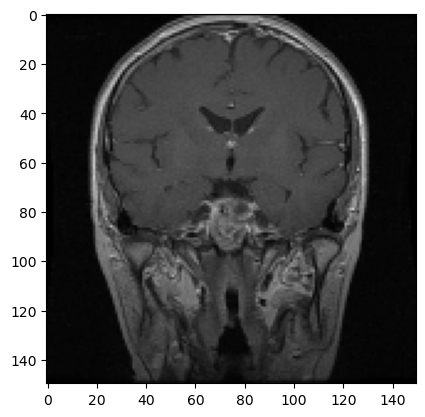

In [4]:
#example
plt.imshow(x_train[0])
plt.show()

In [5]:
x_train.shape,y_train.shape

((3264, 150, 150, 3), (3264,))

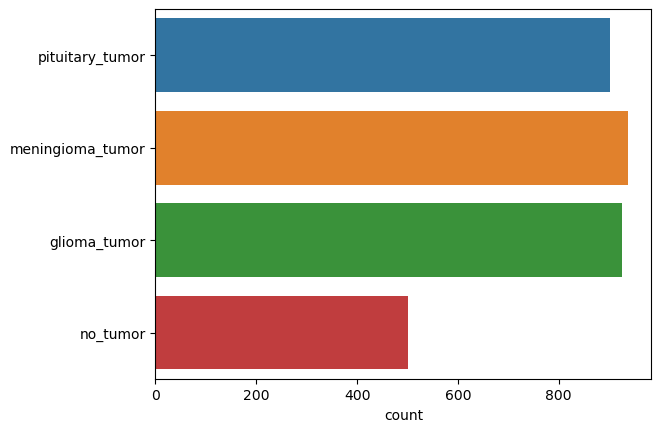

In [6]:
sns.countplot(y = y_train)
plt.show()

Sample of images in each class

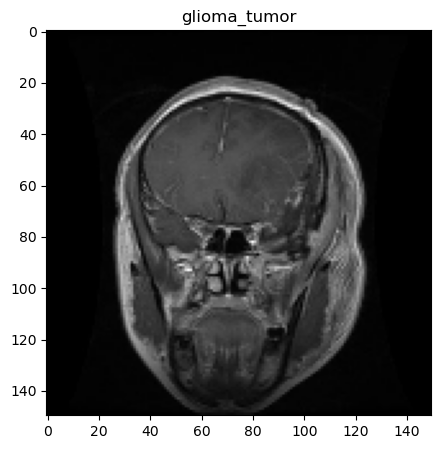

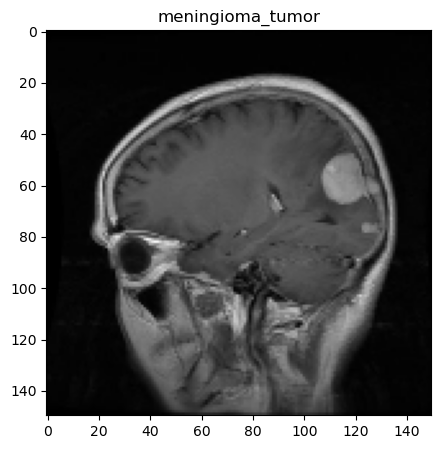

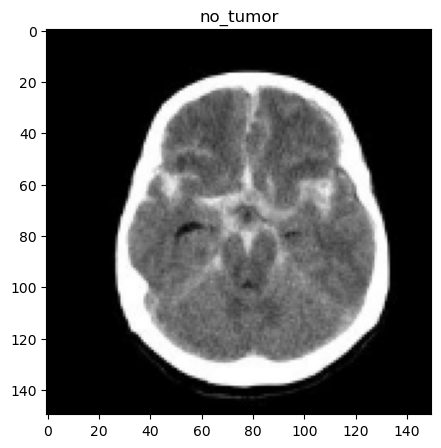

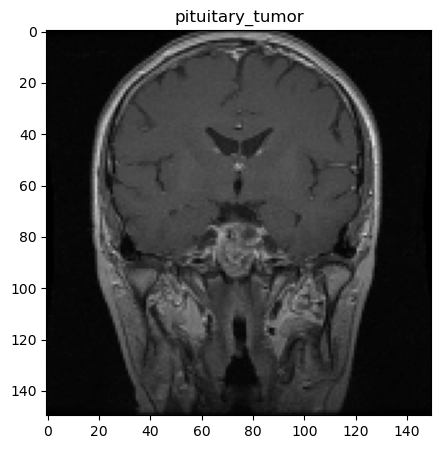

In [7]:
j=0
for i in class_names:
    j=0
    while True :
        if y_train[j]==i:
            plt.figure(figsize = (5,5))
            plt.imshow(x_train[j])
            plt.title(y_train[j])
            break
        j+=1

In [8]:
train_generator = ImageDataGenerator(rotation_range=10, zoom_range=0.10,
width_shift_range=0.10, height_shift_range=0.10, shear_range=0.10,
horizontal_flip=True, fill_mode="nearest")

In [9]:
# Split them into testing and training data
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=99, test_size=0.10)

print("Shapes X : Train :",x_train.shape,  " Test :",x_test.shape)
print("Shapes Y : Train :",y_train.shape,  " Test :",y_test.shape)

Shapes X : Train : (2937, 150, 150, 3)  Test : (327, 150, 150, 3)
Shapes Y : Train : (2937,)  Test : (327,)


Encoding the y_train and y_test to numbers

In [10]:
#for train data
y_train_new = [class_names.index(i) for i in y_train]
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

#for test data
y_test_new = [class_names.index(i) for i in y_test]
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [11]:
# Using the Xception Model
inputShape = (IMAGE_SIZE, IMAGE_SIZE, 3)
xception = Xception(weights="imagenet", input_shape=inputShape, include_top=False)

In [12]:
# Adding the layers of Neural Network
model = xception.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(4, activation='softmax')(model)
model = tf.keras.models.Model(inputs=xception.input, outputs=model)

Model summary

In [13]:
# Model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 150, 150, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 74, 74, 32)        │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, 74, 74, 32)        │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, 74, 74, 32)        │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 72, 72, 64)        │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, 72, 72, 64)        │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, 72, 72, 64)        │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, 72, 72, 128)       │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, 72, 72, 128)       │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, 72, 72, 128)       │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, 72, 72, 128)       │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, 72, 72, 128)       │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 36, 36, 128)       │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 36, 36, 128)       │               

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 20,815,148 (79.40 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [14]:
# Creating callbacks
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("brainTumor.keras",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=VERBOSE, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 2, min_delta = 0.001,mode='max',verbose=VERBOSE)

In [15]:
# Generating customised dataset
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    output_signature=(
        tf.TensorSpec(shape=(None, *x_train.shape[1:]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, *y_train.shape[1:]), dtype=tf.float32)
    )
)
train_dataset = train_dataset.repeat()

Training the model

In [16]:
# Compling and fitting the model
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=(x_test, y_test), steps_per_epoch=len(x_train) // BATCH_SIZE,
                    epochs=12, callbacks=[reduce_lr, checkpoint, tensorboard]) 

Epoch 1/12
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6942 - loss: 0.8175
Epoch 1: val_accuracy improved from -inf to 0.81651, saving model to brainTumor.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 557s 3s/step - accuracy: 0.6946 - loss: 0.8168 - val_accuracy: 0.8165 - val_loss: 0.9005 - learning_rate: 0.0010
Epoch 2/12
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8770 - loss: 0.3854
Epoch 2: val_accuracy improved from 0.81651 to 0.81957, saving model to brainTumor.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 532s 3s/step - accuracy: 0.8770 - loss: 0.3855 - val_accuracy: 0.8196 - val_loss: 0.7688 - learning_rate: 0.0010
Epoch 3/12
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9036 - loss: 0.3121
Epoch 3: val_accuracy improved from 0.81957 to 0.87156, saving model to brainTumor.keras
183/183 ━━━━━━━━━━━━━━━━━━━━ 544s 3s/step - accuracy: 0.9036 - loss: 0.3120 - val_accuracy: 0.8716 - val_loss: 0.5430 - learning_rate: 0.0010
Epoch 4/12
183/183 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - ac

Training, loss vs epoch.

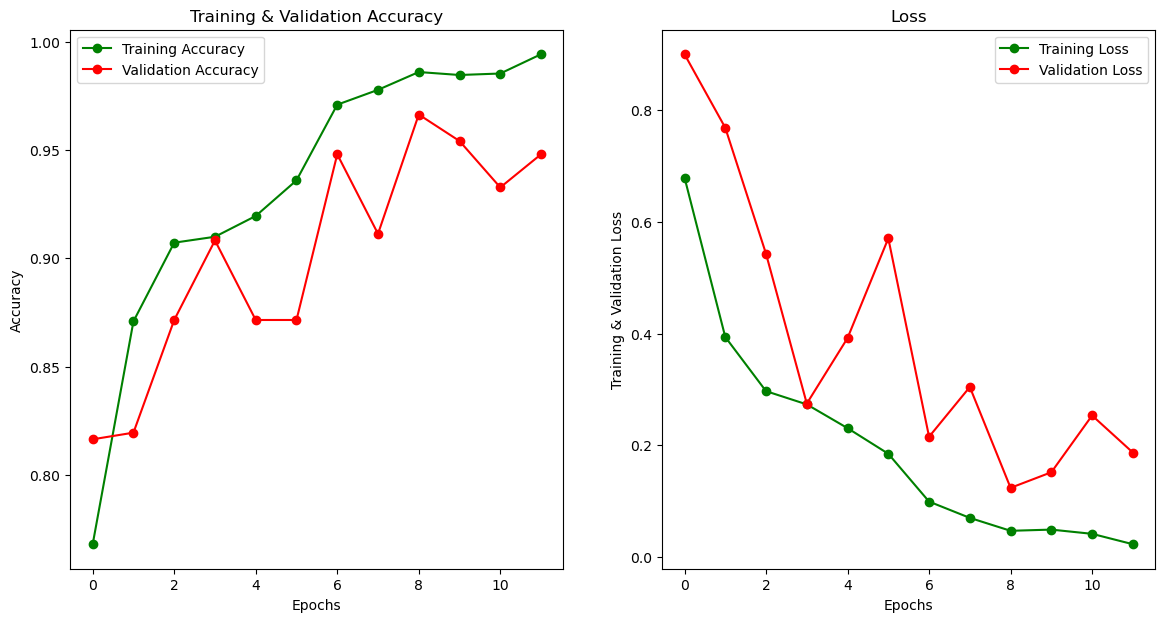

In [17]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

Model performance

In [18]:
# Evaluating Model
result = model.evaluate(x_test, y_test)
print("Testing Loss :", result[0])
print("Testing Accuracy :", result[1]*100, "%")

11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 618ms/step - accuracy: 0.9500 - loss: 0.2220
Testing Loss : 0.18715642392635345
Testing Accuracy : 94.80122327804565 %


In [19]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 703ms/step


Classification Report

In [20]:
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions)
print(cf_report)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       101
           1       0.97      0.91      0.94        93
           2       0.98      0.94      0.96        53
           3       0.90      1.00      0.95        80

    accuracy                           0.95       327
   macro avg       0.95      0.95      0.95       327
weighted avg       0.95      0.95      0.95       327



Confusion Matrix

<Axes: >

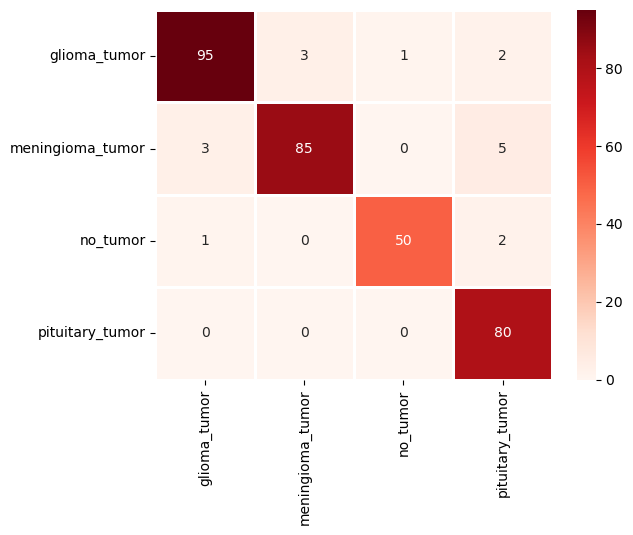

In [21]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions)
sns.heatmap(cf_matrix, cmap = 'Reds', linewidth = 1, annot = True, xticklabels=class_names, yticklabels=class_names)